In [296]:
import time
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import os
import random
import glob
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from torch.utils.data.sampler import SubsetRandomSampler

In [297]:
path_dir = '/Users/swastik/ophthalmology/Datasets/Drive_Dataset'

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [298]:
import torch.utils.data as data

class DataLoaderSegmentation(data.Dataset):
    def __init__(self,folder_path,transform = None):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','*.tif'))
        self.mask_files = glob.glob(os.path.join(folder_path,'new_mask','*.bmp'))
        self.transforms = transform
        #for img_path in img_files:
         #   self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path))
     
    def mask_to_class(self,mask):
        target = torch.from_numpy(mask)
        h,w = target.shape[0],target.shape[1]
        masks = torch.empty(h, w, dtype=torch.long)
        colors = torch.unique(target.view(-1,target.size(2)),dim=0).numpy()
        target = target.permute(2, 0, 1).contiguous()
        mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}
        for k in mapping:
            idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
            validx = (idx.sum(0) == 3) 
            masks[validx] = torch.tensor(mapping[k], dtype=torch.long)
        return masks
    
    def elastic_transform_nearest(self,image, alpha=1000, sigma=20, spline_order=0, mode='nearest', random_state=np.random):
        
        image = np.array(image)
       # assert image.ndim == 3
        shape = image.shape[:2]

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                      sigma, mode="constant", cval=0) * alpha

        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
        indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
        result = np.empty_like(image)
        for i in range(image.shape[2]):
            result[:, :, i] = map_coordinates(
            image[:, :, i], indices, order=spline_order, mode=mode).reshape(shape)
        result = Image.fromarray(result)
        return result
    
    def elastic_transform_bilinear(self,image, alpha=1000, sigma=20, spline_order=1, mode='nearest', random_state=np.random):
        

        image = np.array(image)
        #assert image.ndim == 3
        shape = image.shape[:2]
        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha

        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
        indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
        result = np.empty_like(image)
        for i in range(image.shape[2]):
            result[:, :, i] = map_coordinates(
            image[:, :, i], indices, order=spline_order, mode=mode).reshape(shape)
        result = Image.fromarray(result)
        return result
    
    def transform(self,image,mask):
        i, j, h, w = transforms.RandomCrop.get_params(
        image, output_size=(512, 512))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        
        #image = TF.Lambda(gaussian_blur),
       # mask = 
        #image = TF.Lambda(elastic_transform)
        # Random horizontal flipping
        #image = transforms.transforms.Lambda(gaussian_blur)
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        image = TF.rotate(image,90)
        mask = TF.rotate(mask,90)
        image = TF.rotate(image,180)
        mask = TF.rotate(mask,180)
        image = TF.rotate(image,270)
        mask = TF.rotate(mask,270)

        # Transform to tensor
        #image = TF.to_tensor(image)
#         mask = TF.to_tensor(mask)
        return image, mask
     
    
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        data = Image.open(img_path)
        label = Image.open(mask_path)
       # label = np.array(label)
        data = self.elastic_transform_bilinear(data)
        label = self.elastic_transform_nearest(label)
        data,label = self.transform(data,label)
        label = np.array(label)
        data = np.array(data)
        #label = np.transpose(label,(2,0,1))
        mask = self.mask_to_class(label)
        if transforms is not None:
             data = self.transforms(data)
        return data,mask
       # return data, torch.from_numpy(label).long()
           
    def __len__(self):
        return len(self.img_files)

In [324]:
from skimage.segmentation import find_boundaries

w0 = 10
sigma = 5

def make_weight_map(masks):
    """
    Generate the weight maps as specified in the UNet paper
    for a set of binary masks.
    
    Parameters
    ----------
    masks: array-like
        A 3D array of shape (n_masks, image_height, image_width),
        where each slice of the matrix along the 0th axis represents one binary mask.

    Returns
    -------
    array-like
        A 2D array of shape (image_height, image_width)
    
    """
    nrows, ncols = masks.shape[1:]
    masks = (masks > 0).astype(int)
    distMap = np.zeros((nrows * ncols, masks.shape[0]))
    X1, Y1 = np.meshgrid(np.arange(nrows), np.arange(ncols))
    X1, Y1 = np.c_[X1.ravel(), Y1.ravel()].T
    for i, mask in enumerate(masks):
        # find the boundary of each mask,
        # compute the distance of each pixel from this boundary
        bounds = find_boundaries(mask, mode='inner')
        X2, Y2 = np.nonzero(bounds)
        xSum = (X2.reshape(-1, 1) - X1.reshape(1, -1)) ** 2
        ySum = (Y2.reshape(-1, 1) - Y1.reshape(1, -1)) ** 2
        distMap[:, i] = np.sqrt(xSum + ySum).min(axis=0)
    ix = np.arange(distMap.shape[0])
    if distMap.shape[1] == 1:
        d1 = distMap.ravel()
        border_loss_map = w0 * np.exp((-1 * (d1) ** 2) / (2 * (sigma ** 2)))
    else:
        if distMap.shape[1] == 2:
            d1_ix, d2_ix = np.argpartition(distMap, 1, axis=1)[:, :2].T
        else:
            d1_ix, d2_ix = np.argpartition(distMap, 2, axis=1)[:, :2].T
        d1 = distMap[ix, d1_ix]
        d2 = distMap[ix, d2_ix]
        border_loss_map = w0 * np.exp((-1 * (d1 + d2) ** 2) / (2 * (sigma ** 2)))
    xBLoss = np.zeros((nrows, ncols))
    xBLoss[X1, Y1] = border_loss_map
    # class weight map
    loss = np.zeros((nrows, ncols))
    w_1 = 1 - masks.sum() / loss.size
    w_0 = 1 - w_1
    loss[masks.sum(0) == 1] = w_1
    loss[masks.sum(0) == 0] = w_0
    ZZ = xBLoss + loss
    return ZZ

In [325]:
masks = Image.open('/Users/swastik/ophthalmology/Datasets/Drive_Dataset/new_mask/26.bmp')
masks = np.array(masks)
make_weight_map(masks)

ValueError: zero-size array to reduction operation minimum which has no identity

In [299]:
def elastic_transform_bilinear(image, alpha=1000, sigma=20, spline_order=1, mode='constant', random_state=np.random):
    """Elastic deformation of image as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
#     assert image.ndim == 3
    image = Image.open(image)
    image = np.array(image)
 #   assert image.ndim == 3
    shape = image.shape[:2]

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
    result = np.empty_like(image)
    for i in range(image.shape[2]):
        result[:, :, i] = map_coordinates(
            image[:, :, i], indices, order=spline_order, mode=mode).reshape(shape)
    result = Image.fromarray(result)
    return result

In [300]:
# img = Image.open('/Users/swastik/ophthalmology/Datasets/Drive_Dataset/images/21.tif')
# cvimg = cv2.imread('/Users/swastik/ophthalmology/Datasets/Drive_Dataset/images/21.tif')
# mask = Image.open('/Users/swastik/ophthalmology/Datasets/Drive_Dataset/mask/40.bmp')
folder_path = '/Users/swastik/ophthalmology/Datasets/Drive_Dataset'
mask_files = glob.glob(os.path.join(folder_path,'images','*.tif'))
# imgs = np.array(img)
# imgs = np.transpose(imgs,(2,0,1))
# # img =torch.from_numpy(img).long()
# #imgs.shape
# imgs.shape
# img = elastic_transform_bilinear(mask)
# img = gaussian_blur(img)
# img
for i in mask_files:
    img = elastic_transform_bilinear(i)
#     img.show()

In [301]:
def gaussian_blur(img):
    image = np.array(img)
    image_blur = cv2.GaussianBlur(image,(65,65),10)
    new_image = image - image_blur
    im = Image.fromarray(new_image)
    return im

In [302]:
def elastic_transform_nearest(image, alpha=1000, sigma=20, spline_order=0, mode='nearest', random_state=np.random):
    """Elastic deformation of image as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
#     assert image.ndim == 3
    image = np.array(image)
   # assert image.ndim == 3
    shape = image.shape[:2]

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
    result = np.empty_like(image)
    for i in range(image.shape[2]):
        result[:, :, i] = map_coordinates(
            image[:, :, i], indices, order=spline_order, mode=mode).reshape(shape)
    result = Image.fromarray(result)
    return result

In [303]:
a = np.arange(12.).reshape((4, 3))
inds = np.array([[0], [0.7]]) 
inds
# map_coordinates(a, inds, order=1,mode = 'constant') # returns [1.0]
map_coordinates(a, inds, order=1,mode = 'nearest')

array([0.7])

In [304]:
def elastic_transform_bilinear(image, alpha=1000, sigma=20, spline_order=1, mode='constant', random_state=np.random):
    """Elastic deformation of image as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
#     assert image.ndim == 3
    
    image = np.array(image)
 #   assert image.ndim == 3
    shape = image.shape[:2]

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
    result = np.empty_like(image)
    for i in range(image.shape[2]):
        result[:, :, i] = map_coordinates(
            image[:, :, i], indices, order=spline_order, mode=mode).reshape(shape)
    result = Image.fromarray(result)
    return result

In [305]:

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Gpu is being used")
else:
    print("No gpu")

No gpu


In [306]:
batch_size = 5

In [307]:
dataset = DataLoaderSegmentation(path_dir,transform = transforms.ToTensor())
train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=False)


In [308]:
for image,labels in iter(train_loader):
#     labels = labels.view(labels.shape[:2],-1)
    print(image.shape)
    print(labels.shape)
    break

torch.Size([5, 3, 512, 512])
torch.Size([5, 512, 512])


In [309]:
train_mean = []
train_std = []

for i,image in enumerate(train_loader,0):
#      image[0].shape()
    numpy_image = image[0].numpy()
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)
    
train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

print('Mean:', train_mean)
print('Std Dev:', train_std)

Mean: tensor([0.5971, 0.3220, 0.1907])
Std Dev: tensor([0.3020, 0.1693, 0.0962])


In [310]:
import torchvision.transforms as transforms
data_transforms = transforms.Compose([
                                 transforms.Lambda(gaussian_blur),
                                 #transforms.Lambda(elastic_transform),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=train_mean, std=train_std)
                               ])
final_dataset = DataLoaderSegmentation(path_dir,transform = data_transforms)

In [311]:
validation_split = 0.15
shuffle_dataset = True
random_seed = 42

dataset_size = len(final_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split*dataset_size))
if shuffle_dataset: 
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]


In [312]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [313]:
len(train_sampler),len(valid_sampler)

(17, 3)

In [314]:
final_train_loader = DataLoader(dataset=final_dataset, batch_size = batch_size,sampler = train_sampler)
final_valid_loader = DataLoader(dataset=final_dataset, batch_size = batch_size,sampler = valid_sampler)

In [315]:
# Checking the dataset
for idx,(images, labels) in enumerate(final_train_loader):  
    print("Batch is: ",idx)
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Batch is:  0
Image batch dimensions: torch.Size([5, 3, 512, 512])
Image label dimensions: torch.Size([5, 512, 512])


In [316]:
for idx,(images, labels) in enumerate(final_valid_loader): 
    print("Batch is: ",idx)
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Batch is:  0
Image batch dimensions: torch.Size([3, 3, 512, 512])
Image label dimensions: torch.Size([3, 512, 512])


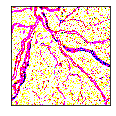

In [263]:
dataiter = iter(final_train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(5,4))

for idx in np.arange(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)).astype(np.uint8))
    plt.savefig("img")
    break

In [317]:
import torch.nn as nn
import torch.nn.functional as F

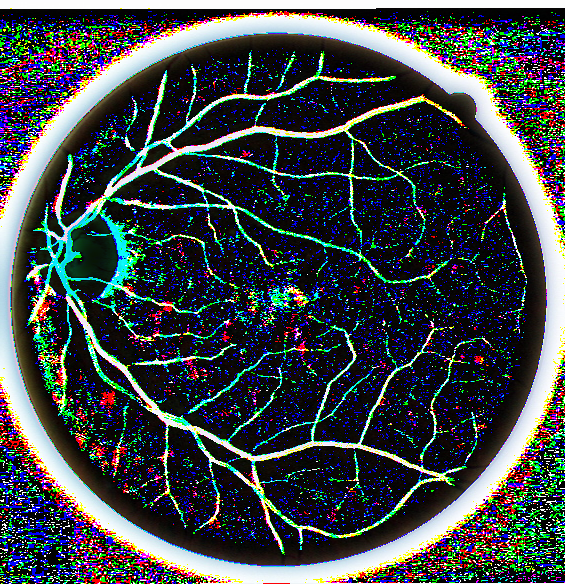

In [318]:
path_dir = '/Users/swastik/ophthalmology/Datasets/Drive_Dataset/images/21.tif'
img = Image.open(path_dir)
image = np.array(img)
image_blur = cv2.GaussianBlur(image,(65,65),10)
new_image = image - image_blur
im = Image.fromarray(new_image)
im

In [71]:
# model = UNet()
# print(model)

In [319]:
class Unet(nn.Module):
    def contracting_block(self,in_channels,out_channels,kernel_size = 5):
        block = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,out_channels = out_channels,kernel_size = kernel_size,padding = 2),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels,eps = 1e-03, momentum = 0.99),
            nn.Conv2d(in_channels = out_channels,out_channels = out_channels,kernel_size = kernel_size, padding = 2),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels,eps = 1e-03, momentum = 0.99)
        )
        return block
      
    def expansive_block(self,in_channels,mid_channel,out_channels,kernel_size = 5):
        block = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,out_channels = mid_channel,kernel_size = kernel_size,padding = 2 ),
            nn.ReLU(),
            nn.BatchNorm2d(mid_channel,eps = 1e-03,momentum = 0.99),
            nn.Conv2d(in_channels = mid_channel, out_channels = mid_channel,kernel_size = kernel_size, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(mid_channel),
            nn.ConvTranspose2d(in_channels = mid_channel,out_channels = out_channels,kernel_size = 2,stride = 2,padding = 0,output_padding=0)
        ) 
        return block
    
    def final_block(self,in_channels,mid_channels,out_channels,kernel_size = 5):
        block = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,out_channels = mid_channels,kernel_size = kernel_size,padding = 2),
            nn.ReLU(),
            nn.BatchNorm2d(mid_channels,eps = 1e-03,momentum = 0.99),
            nn.Conv2d(in_channels = mid_channels,out_channels = mid_channels,kernel_size = kernel_size,padding = 2),
            nn.ReLU(),
            nn.BatchNorm2d(mid_channels,eps = 1e-03,momentum = 0.99),
            nn.Conv2d(kernel_size = 1,in_channels=mid_channels, out_channels=out_channels),
            nn.Softmax(),
            
        )    
        return block
    
    def __init__(self,in_channel,out_channel):
        super(Unet,self).__init__()
        self.conv_encode1 = self.contracting_block(in_channels = in_channel,out_channels = 16)
        self.conv_maxpool1 = nn.MaxPool2d(kernel_size=2,stride = 2)
        self.conv_encode2 = self.contracting_block(16, 32)
        self.conv_maxpool2 = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.conv_encode3 = self.contracting_block(32, 64)
        self.conv_maxpool3 = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.conv_encode4 = self.contracting_block(64,128)
        self.conv_maxpool4 = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.bottleneck = nn.Sequential(
                            nn.Conv2d(kernel_size=5, in_channels=128, out_channels=256,padding = 2),
                            nn.ReLU(),
                            nn.BatchNorm2d(256),
                            nn.Dropout(0.2),
                            nn.Conv2d(kernel_size=5, in_channels=256, out_channels=256, padding = 2),
                            nn.ReLU(),
                            nn.BatchNorm2d(256),
                            nn.Dropout(0.2),
                            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0, output_padding=0)
                            )
        
        self.conv_decode3 = self.expansive_block(256, 128, 64)
        self.conv_decode2 = self.expansive_block(128, 64, 32)
        self.conv_decode1 = self.expansive_block(64,32,16)
        self.final_layer = self.final_block(16, 16, out_channel)
        
               
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        encode_block4 = self.conv_encode4(encode_pool3)
        encode_pool4 = self.conv_maxpool4(encode_block4)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool4)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block4, crop=True)
        cat_layer3 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer3, encode_block3, crop=True)
        cat_layer2 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode1(decode_block1)
        final_layer = self.final_layer(cat_layer1)
        return  final_layer
    

In [320]:
unet = Unet(in_channel=3,out_channel=4)
print(unet)

Unet(
  (conv_encode1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  )
  (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  )
  (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode3

In [321]:
# Move models to CUDA
if train_on_gpu:
    unet = unet.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr = 0.001)

In [322]:
# print("Model's state_dict:")
# for param_tensor in unet.state_dict():
#     print(param_tensor, "\t", unet.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [5001243096, 5001242736, 5001244032, 4985950568, 5001243960, 5001243888, 4996660176, 5001243384, 4996658160, 4986266896, 4986267112, 4998741448, 4998739720, 4998739144, 4998739000, 4998738784, 4988202944, 5002381136, 5002382432, 5002379840, 5002382648, 5002381064, 5001436976, 5001435392, 5001436328, 5001436472, 5001436544, 5001434240, 5001435536, 5001434888, 5001436256, 5001435104, 5001436616, 5001435968, 5001435032, 5002375384, 5001309136, 5001309064, 5001309280, 5001309712, 5001308632, 5001307984, 5001306688, 5001309424, 5001306976, 5001308056, 5001309352, 5001306904, 5001308848, 5001308128, 4428138176, 4428139256, 4990148968, 4990149544, 4987737360, 4991929512, 4990071288, 4990073592, 4990071144, 4988767688, 5001222472, 5001220168, 5001222688, 5001222904, 5001221608, 5001221464, 5001222040, 5001220528, 5001221320, 5001221536, 5001222328

In [144]:
# def get_val_loss(x_val, y_val):
#     x_val = torch.from_numpy(x_val).float()
#     y_val = torch.from_numpy(y_val).long()
#     if use_gpu:
#         x_val = x_val.cuda()
#         y_val = y_val.cuda()
#     m = x_val.shape[0]
#     outputs = unet(x_val)
#     # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
#     outputs = outputs.permute(0, 2, 3, 4)
#     # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
#     outputs = outputs.resize(m*width_out*height_out, 2)
#     labels = y_val.resize(m*width_out*height_out)
#     loss = F.cross_entropy(outputs, labels)
#     return loss.data

In [145]:
# epoch_iter = np.ceil(final_train_sampler.shape[0] / batch_size).astype(int)
# t = trange(epochs, leave=True)
# for _ in t:
#     total_loss = 0
#     for i in range(epoch_iter):
#         batch_train_x = torch.from_numpy(final_train_sampler[i * batch_size : (i + 1) * batch_size]).float()
#         batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
#         if use_gpu:
#             batch_train_x = batch_train_x.cuda()
#             batch_train_y = batch_train_y.cuda()
#         batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
#         total_loss += batch_loss
#     if (_+1) % epoch_lapse == 0:
#         val_loss = get_val_loss(final_valid_loader, y_val)
#         print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

In [323]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(final_train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(final_valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output,target)
            valid_loss +=  valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model
model_scratch = train(20, final_train_loader, unet, optimizer, 
                      criterion, train_on_gpu, 'model_scratch.pt')



/Users/swastik/opt/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 	Training Loss: 1.419658 	Validation Loss: 1.406983
Validation loss decreased (inf --> 1.406983).  Saving model ...


KeyboardInterrupt: 

In [ ]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt')) 

In [ ]:
import torch

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Create dummy target image
nb_classes = 19 - 1 # 18 classes + background
idx = np.linspace(0., 1., nb_classes)
cmap = matplotlib.cm.get_cmap('viridis')
rgb = cmap(idx, bytes=True)[:, :3]  # Remove alpha value

rgb.shape



In [ ]:
h, w = 190, 100
rgb = rgb.repeat(1000, 0)
rgb.shape

In [ ]:
target = np.zeros((h*w, 3), dtype=np.uint8)
target[:rgb.shape[0]] = rgb
target = target.reshape(h, w, 3)
target.shape



In [ ]:
plt.imshow(target) # Each class in 10 rows

In [ ]:
# Create mapping
# Get color codes for dataset (maybe you would have to use more than a single
# image, if it doesn't contain all classes)
target = torch.from_numpy(target)
h,w = target.shape[0],target.shape[1]
# colors = torch.unique(target.view(-1, target.size(2)), dim=0).numpy()
# colors.shape
type(h)


In [ ]:
target = target.permute(2, 0, 1).contiguous()
target.shape

In [ ]:
for k in mapping:
    mask[validx] = torch.tensor(mapping[k], dtype=torch.long)
    break

In [ ]:
if a.sum(0) == 3:
    print("hey")

In [ ]:
mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}

mask = torch.empty(h, w, dtype=torch.long)
for k in mapping:
    # Get all indices for current class
    idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
    validx = (idx.sum(0) == 3)  # Check that all channels match
    mask[validx] = torch.tensor(mapping[k], dtype=torch.long)
    print(mask[validx])
    break

In [ ]:
lt = (1,2,4)
inputs = torch.tensor(lt,dtype = torch.uint8) # input: 2 x 4 x 3
inputs.shape
# inputs.unsqueeze(1).unsqueeze(2).shape

In [ ]:
valid =  (target.sum(0) == 3)


In [ ]:
valid.shape

In [ ]:
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

In [ ]:
bypass = torch.Tensor(128,64,64)
upsampled = torch.Tensor(128,64,64)
bypass.shape

In [ ]:
c = (bypass.size()[2] - upsampled.size()[2]) // 2
bypass = F.pad(bypass, (-c, -c, -c, -c))
bypass.shape
d = torch.cat((upsampled, bypass), 1)
d.shape

In [ ]:
!jupyter nbconvert --to script Preprocessing.ipynb

In [ ]:
x = torch.randn(128, 64, 64)
y = torch.randn(128,64, 64)
x.shape

In [ ]:
z = torch.cat((x,y),1)

In [ ]:
z.shape

In [ ]:
#img = Image.open('/Users/swastik/ophthalmology/Datasets/Drive_Dataset/images/22.tif')
img = Image.open('/Users/swastik/ophthalmology/Datasets/AV_Dataset_Segmentation/Drive_AV_evalmasks/Eroded_AV/Centerline/01_skeleton.png')

In [ ]:
img = np.array(img)
img.shape

In [ ]:
target = torch.from_numpy(img)
h,w = target.shape[0],target.shape[1]
masks = torch.empty(h, w, dtype=torch.long)
colors = torch.unique(target.view(-1,target.size(2)),dim=0).numpy()
(colors.tolist())

# target = target.permute(2, 0, 1).contiguous()
# mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}
# for k in mapping:
#     idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
#     validx = (idx.sum(0) == 3) 
#     masks[validx] = torch.tensor(mapping[k], dtype=torch.long)

In [194]:
path_dir = '/Users/swastik/ophthalmology/Datasets/Drive_Dataset'
masking = Image.open('/Users/swastik/ophthalmology/Datasets/Drive_Dataset/mask/40.bmp')
#masking = Image.open('/Users/swastik/ophthalmology/Datasets/AV_Dataset_Segmentation/HRF_AV_GT/01_dr_AVmanual.png')
masking = np.array(masking)

In [131]:
def mask_to_class(mask):
    target = torch.from_numpy(mask)
    h,w = target.shape[0],target.shape[1]
    masks = torch.empty(h, w, dtype=torch.long)
    colors = torch.unique(target.view(-1,target.size(2)),dim=0).numpy()
    target = target.permute(2, 0, 1).contiguous()
    mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}
    for k in mapping:
        idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
        validx = (idx.sum(0) == 3) 
        masks[validx] = torch.tensor(mapping[k], dtype=torch.long)
    return masks

In [132]:
img = mask_to_class(masking)

In [133]:
img.shape

torch.Size([2336, 3504])

In [195]:
target = torch.from_numpy(masking)
h,w = target.shape[0],target.shape[1]
masks = torch.empty(h, w, dtype=torch.long)

In [196]:
colors = torch.unique(target.view(-1,target.size(2)),dim=0).numpy()
target = target.permute(2, 0, 1).contiguous()

In [197]:
colors.shape

(4, 3)

In [137]:
target.shape

torch.Size([3, 2336, 3504])

In [138]:
mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}

In [139]:
for k in mapping:
    idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
    validx = (idx.sum(0) == 3) 
    masks[validx] = torch.tensor(mapping[k], dtype=torch.long)

In [140]:
masks

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])